<a href="https://colab.research.google.com/github/PureVice/workshop-data-science-aplicada-ao-futebol/blob/main/baseline_xg_fame25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse notebook mostra como implementar um modelo de Expectativa de Gols do zero até ter ele completo.

# xG

## Instalação
Não altere nenhuma célula desta seção e execute-a.

In [ ]:
base_url = 'https://drive.google.com/uc?id={file_id}'

shots_file_id = '1GmEtAMMef7Pp2odFO7q_Ijl4gUsS8Yk2'
gandula_file_id = '1iDw-Rc56-ZvwBpjHwZh4HdH7AozdqoiL'

In [ ]:
!gdown {gandula_file_id} -O gandula_view.py

Downloading...
From (original): https://drive.google.com/uc?id=1iDw-Rc56-ZvwBpjHwZh4HdH7AozdqoiL
From (redirected): https://drive.google.com/uc?id=1iDw-Rc56-ZvwBpjHwZh4HdH7AozdqoiL&confirm=t&uuid=34db4c63-4179-41ab-a72f-352d8cfc7fa5
To: /content/gandula_view.py
100% 3.77k/3.77k [00:00<00:00, 20.9MB/s]


In [ ]:
!pip install mplsoccer

## Imports
Não exclua nenhuma célula desta seção e execute-a.

In [ ]:
import gandula_view

In [ ]:
from gandula_view import view_shot
from gandula_view import view_shot_map
from gandula_view import get_custom_pitch

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Coleta de dados

A Gradient fornece dois tipos de dado, que podem vir de jeitos diferentes:

- dados de evento: json ou via API
- dados de tracking: json

Os dados (frames) de todos os **chutes** de todas as partidas do dataset completo (tracking da Copa do Mundo de 2022) já foram selecionados e estão disponíveis publicamente para facilitar nossa vida.

A seguir vamos importar esses dados pré-processados e analisar seu formato. Podemos extraí-los da seguinte forma:

In [ ]:
df = pd.read_json(base_url.format(file_id=shots_file_id))

## Exploração dos dados

Vamos primeiro ver como os chutes aparecem.

In [ ]:
df[:20]

,game_id,game_event_type,possession_event_type,period,timestamp,player_id,player_name,x,y,body_part,...,set_piece,shot_height,shot_nature,shot_type,game_event id,possession_event_id,possession_event_video_url,home_players,away_players,ball
0,3812,OTB,SHOT,1,186.119,7988,Boulaye Dia,40.435,11.735,LEFT FOOT,...,None,BOTTOM THIRD,POWER,VOLLEY,6497564,6373889,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'LOW', 'visib...","[{'jerseyNum': 8, 'confidence': 'LOW', 'visibi...","[{'visibility': 'VISIBLE', 'x': 42.31, 'y': 9...."
1,3812,OTB,SHOT,1,376.610,3315,Vincent Janssen,37.974,5.910,LEFT FOOT,...,None,BOTTOM THIRD,POWER,STANDARD,6497997,6374348,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'LOW', 'visib...","[{'jerseyNum': 8, 'confidence': 'HIGH', 'visib...","[{'visibility': 'VISIBLE', 'x': 38.23, 'y': 6...."
2,3812,OTB,SHOT,1,669.436,428,Ismaïla Sarr,32.339,-4.970,LEFT FOOT,...,None,OVER,PLACED,SIDE_FOOT,6498511,6374842,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'LOW', 'visib...","[{'jerseyNum': 8, 'confidence': 'HIGH', 'visib...","[{'visibility': 'ESTIMATED', 'x': 33.31, 'y': ..."
3,3812,OTB,SHOT,1,915.516,214,Nampalys Mendy,34.578,-5.292,RIGHT FOOT,...,None,BOTTOM THIRD,POWER,STANDARD,6498707,6375034,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'LOW', 'visib...","[{'jerseyNum': 8, 'confidence': 'LOW', 'visibi...","[{'visibility': 'ESTIMATED', 'x': 35.05, 'y': ..."
4,3812,OTB,SHOT,1,1118.919,8026,Daley Blind,46.561,8.293,HEAD,...,None,BOTTOM THIRD,PLACED,STANDARD,6497505,6373830,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'HIGH', 'visi...","[{'jerseyNum': 8, 'confidence': 'LOW', 'visibi...","[{'visibility': 'ESTIMATED', 'x': 51.68, 'y': ..."
5,3812,OTB,SHOT,1,1272.706,3315,Vincent Janssen,32.509,-3.839,LEFT FOOT,...,None,BOTTOM THIRD,POWER,STANDARD,6497601,6373926,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'HIGH', 'visi...","[{'jerseyNum': 8, 'confidence': 'HIGH', 'visib...","[{'visibility': 'VISIBLE', 'x': 32.07, 'y': -0..."
6,3812,OTB,SHOT,1,1619.987,428,Ismaïla Sarr,37.206,14.123,RIGHT FOOT,...,None,TOP THIRD,PLACED,STANDARD,6497888,6374219,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'LOW', 'visib...","[{'jerseyNum': 8, 'confidence': 'MEDIUM', 'vis...","[{'visibility': 'VISIBLE', 'x': 38.21, 'y': 11..."
7,3812,OTB,SHOT,1,1739.373,37,Virgil van Dijk,47.509,-2.147,HEAD,...,None,BOTTOM THIRD,PLACED,STANDARD,6498013,6374343,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'HIGH', 'visi...","[{'jerseyNum': 8, 'confidence': 'LOW', 'visibi...","[{'visibility': 'ESTIMATED', 'x': 47.65, 'y': ..."
8,3812,OTB,SHOT,1,1841.241,3858,Idrissa Gueye,34.868,-7.801,RIGHT FOOT,...,None,BOTTOM THIRD,POWER,STANDARD,6498116,6374446,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'HIGH', 'visi...","[{'jerseyNum': 8, 'confidence': 'HIGH', 'visib...","[{'visibility': 'ESTIMATED', 'x': 35.39, 'y': ..."
9,3812,OTB,SHOT,1,1856.723,3903,Krépin Diatta,34.338,-18.319,LEFT FOOT,...,None,GROUND,POWER,STANDARD,6498135,6374465,https://epitome.pff.com/en/film_room/87f7e9ab-...,"[{'jerseyNum': 21, 'confidence': 'MEDIUM', 'vi...","[{'jerseyNum': 8, 'confidence': 'LOW', 'visibi...","[{'visibility': 'ESTIMATED', 'x': 35.86, 'y': ..."


Vamos entender um pouco melhor sobre cada frame, usando o chute no índice 6, ou sétima linha, como exemplo. O gandula nos ajuda também na visualização.

game_id                                                                    3812
game_event_type                                                             OTB
possession_event_type                                                      SHOT
period                                                                        1
timestamp                                                              1619.987
player_id                                                                   428
player_name                                                        Ismaïla Sarr
x                                                                        37.206
y                                                                        14.123
body_part                                                            RIGHT FOOT
outcome                                                       On Target Blocked
set_piece                                                                  None
shot_height                             

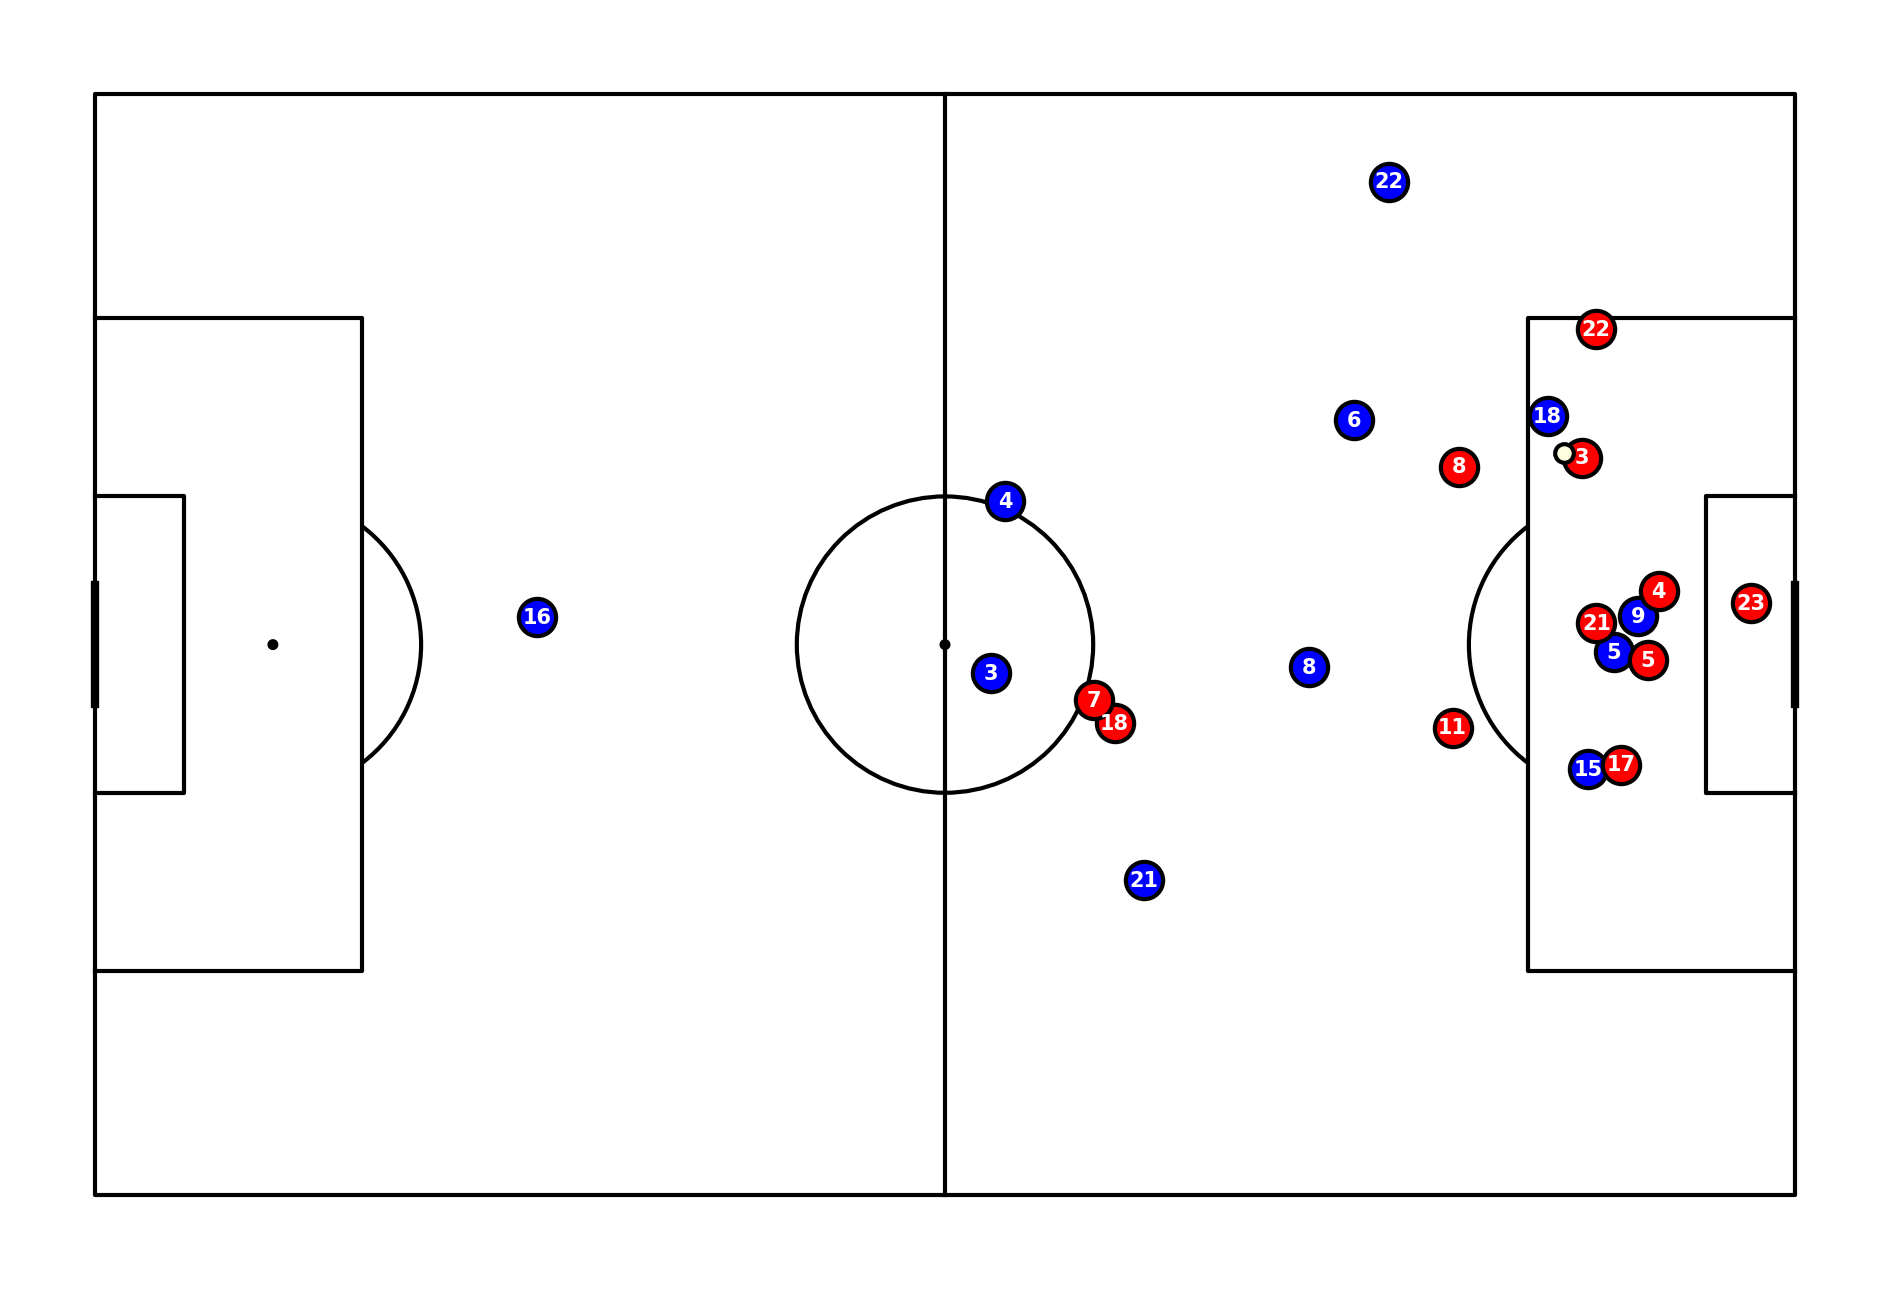

In [ ]:
view_shot(df.loc[6])

Parece ser um chute do número 18 do time de azul!

Como podemos visualizar este chute em seu formato original?

Como está codificado este frame?

In [ ]:
df.loc[6]

,6
game_id,3812
game_event_type,OTB
possession_event_type,SHOT
period,1
timestamp,1619.987
player_id,428
player_name,Ismaïla Sarr
x,37.206
y,14.123
body_part,RIGHT FOOT


## Tratamento dos dados

No modelo de xG que vamos desenvolver aqui, vamos precisar extrair o ângulo para o gol e a distância. Além disso, é necessário saber se o chute resultou em gol ou não. Vamos gerar esses dados para cada chute.

Antes de tudo, vamos ver quantos chutes (linhas) temos no total, e se possuímos a quantidade de colunas esperada.

In [ ]:
df.shape

(1494, 21)

Para extrair a distância, vamos utilizar a distância euclideana. Para fazer o cálculo, precisamos considerar que os chutes podem sair dos dois lados do campo. A PFF tem como padrão nos seus dados direcionar o campo de acordo com o que a câmera mostra na transmissão. Além disso, as coordenadas são centralizadas no meio de campo. Vamos assumir que os atacantes estão sempre no campo adversário para chutar. Com isso, conseguimos extrair corretamente o dado.

Iremos setar como padrão que o time que está chutando ataca sempre da esquerda para a direita, para facilitar o cálculo. Isso quer dizer que o centro do gol está sempre na coordenada y = 0 e x = 52.5. O dataset dos chutes já conta com a correção do lado dos ataques ataques. Vamos calcular a distância.

In [ ]:
# calculando a distância do chute para o gol
df['dist'] = np.sqrt((df['x'] - 52.5) ** 2 + (df['y'] - 0) ** 2)

df.head()[['player_id', 'player_name', 'x', 'y', 'outcome', 'set_piece', 'body_part', 'dist']]

,player_id,player_name,x,y,outcome,set_piece,body_part,dist
0,7988,Boulaye Dia,40.435,11.735,On Target Blocked,None,LEFT FOOT,16.830759
1,3315,Vincent Janssen,37.974,5.910,On Target Blocked,None,LEFT FOOT,15.682244
2,428,Ismaïla Sarr,32.339,-4.970,Off Target,None,LEFT FOOT,20.764557
3,214,Nampalys Mendy,34.578,-5.292,On Target Blocked,None,RIGHT FOOT,18.686983
4,8026,Daley Blind,46.561,8.293,Off Target,None,HEAD,10.200273


Para extrair o ângulo, precisamos pensar na geometria do chute.
Para calcular o ângulo do gol, θ, tomamos a coordenada (x,y) do chute
- x é a distância ao longo da borda do campo desde a linha do gol;
- y é a distância do meio do campo.
- (0,0) é o ponto na linha de fundo no meio do gol.
O ângulo entre dois vetores que apontam para as traves é:
$$
\tan(\theta) = \frac{7.32x}{x^2 + y^2 - \left(\frac{7.32}{2}\right)^2}
$$
- onde 7.32 é o tamanho do gol.


In [ ]:
df['ang'] = np.arctan((7.32 * df['x']) / (df['x'] ** 2 + (7.32 - df['y']) ** 2))

df.head()[['player_id', 'player_name', 'x', 'y', 'outcome', 'set_piece', 'body_part', 'dist', 'ang']]

,player_id,player_name,x,y,outcome,set_piece,body_part,dist,ang
0,7988,Boulaye Dia,40.435,11.735,On Target Blocked,None,LEFT FOOT,16.830759,0.177026
1,3315,Vincent Janssen,37.974,5.910,On Target Blocked,None,LEFT FOOT,15.682244,0.190172
2,428,Ismaïla Sarr,32.339,-4.970,Off Target,None,LEFT FOOT,20.764557,0.195266
3,214,Nampalys Mendy,34.578,-5.292,On Target Blocked,None,RIGHT FOOT,18.686983,0.184709
4,8026,Daley Blind,46.561,8.293,Off Target,None,HEAD,10.200273,0.155870


Por fim, vamos extrai quando temos um gol e quando não.

In [ ]:
df['gol'] = df['outcome'] == 'Goal'
df.head()[['player_id', 'player_name', 'x', 'y', 'outcome', 'set_piece', 'body_part', 'dist', 'ang', 'gol']]

,player_id,player_name,x,y,outcome,set_piece,body_part,dist,ang,gol
0,7988,Boulaye Dia,40.435,11.735,On Target Blocked,None,LEFT FOOT,16.830759,0.177026,False
1,3315,Vincent Janssen,37.974,5.910,On Target Blocked,None,LEFT FOOT,15.682244,0.190172,False
2,428,Ismaïla Sarr,32.339,-4.970,Off Target,None,LEFT FOOT,20.764557,0.195266,False
3,214,Nampalys Mendy,34.578,-5.292,On Target Blocked,None,RIGHT FOOT,18.686983,0.184709,False
4,8026,Daley Blind,46.561,8.293,Off Target,None,HEAD,10.200273,0.155870,False


Além do ângulo, é importante temos mais insighs sobre comos chutes são feitos e sua distribuição

In [ ]:
df['body_part'].value_counts()

,count
body_part,
RIGHT FOOT,752
LEFT FOOT,458
HEAD,261
RIGHT BACK HEEL,4
LEFT KNEE,4
RIGHT SHIN,4
LEFT SHOULDER,3
RIGHT KNEE,2
RIGHT THIGH,2


In [ ]:
df['set_piece'].value_counts()

,count
set_piece,
FREE KICK,44


In [ ]:
df['gol'].sum() / df['gol'].count()

np.float64(0.11579651941097724)

Antes de continuar, vamos limpar um pouco o dado. A natureza de cabeceios é um pouco diferente de chutes. Vamos buscar analisar apenas chutes.

In [ ]:
body_part_chutes = ['RIGHT FOOT', 'LEFT FOOT', 'RIGHT KNEE', 'LEFT KNEE', 'RIGHT BACK HEEL', 'LEFT BACK HEEL', 'RIGHT THIGH', 'LEFT THIGH']

In [ ]:
shots = df[df['body_part'].isin(body_part_chutes)]

Vamos agora entender um pouco mais sobre como esssas mediads influenciam em obter um gol ou não.

## Análise: Distância do Gol

A primeira intuição que temos é que quanto mais distante do gol, mais difícil de se marcar um gol. Vamos verificar se esse é o caso.

Vamos usar o gandula para plotar a distribuição dos chutes que nos selecionamos e também plotar quais desses chutes resultam em gols.

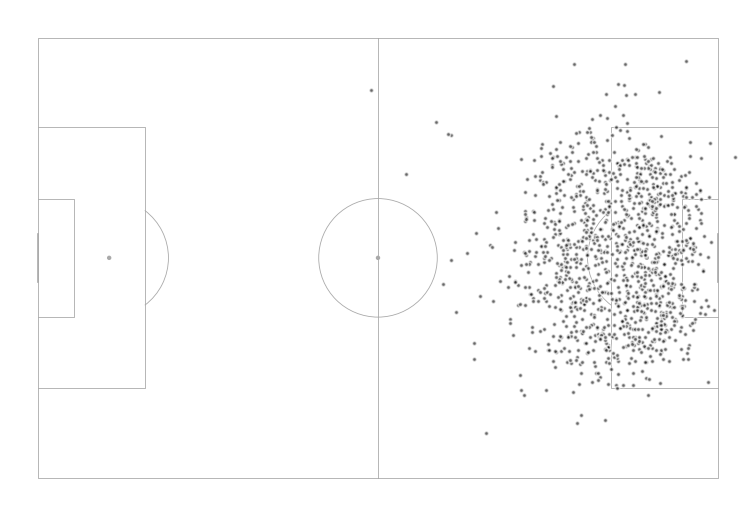

In [ ]:
view_shot_map(shots)

In [ ]:
shots[shots['gol']].shape

(143, 24)

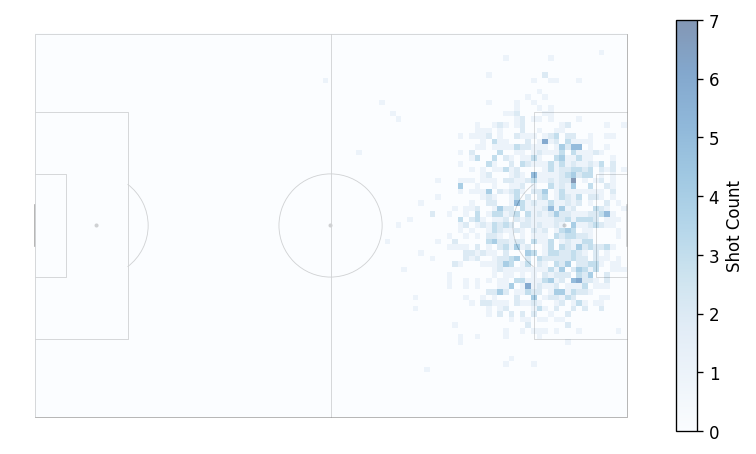

In [ ]:
view_shot_map(shots, circle=False, distribution=True)

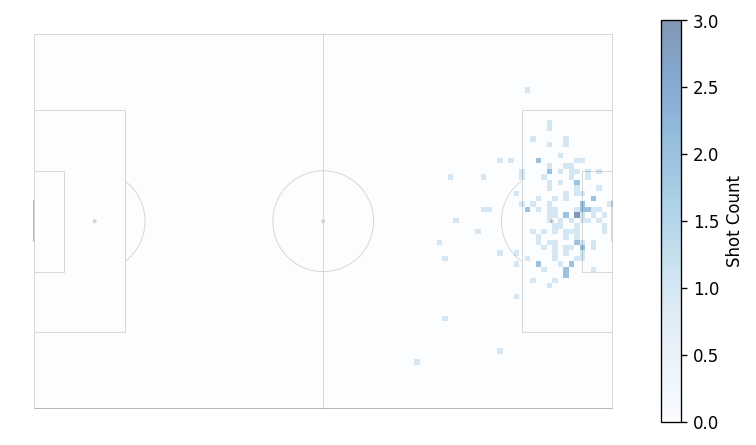

In [ ]:
view_shot_map(shots[shots['gol']], circle=False, distribution=True)

Bem, se temos o número de chutes em cada quadrante do campo, e o número de gols em cada um deles, podemos dividí-los, e teremos a probabilidade de termos um gol em cada quadrante.

/tmp/ipython-input-2981396979.py:23: RuntimeWarning: invalid value encountered in divide
  prob_goal = statistic_goals / statistic_shots


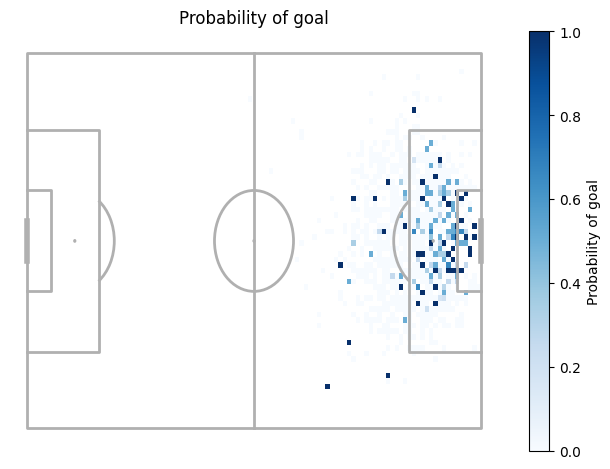

In [ ]:
shots_for_plot = shots.copy()

# puts data on [0,105],[0,68] instead of [-52.5,52.5],[-34,34]
shots_for_plot.loc[:, 'x'] = shots_for_plot.loc[:, 'x'] + 105 / 2
shots_for_plot.loc[:, 'y'] = shots_for_plot.loc[:, 'y'] + 68 / 2

goals_for_plot = shots_for_plot[shots_for_plot['gol']]

pitch = get_custom_pitch()
fig, ax = pitch.draw()

x_bins = np.arange(0, 105 + 1)
y_bins = np.arange(0, 68 + 1)

statistic_shots, _, _ = np.histogram2d(
    shots_for_plot['x'], shots_for_plot['y'], bins=[x_bins, y_bins]
)

statistic_goals, _, _ = np.histogram2d(
    goals_for_plot['x'], goals_for_plot['y'], bins=[x_bins, y_bins]
)

prob_goal = statistic_goals / statistic_shots

plt.imshow(
    prob_goal.T,
    origin='lower',
    extent=(0, 105, 0, 68),
    aspect='auto',
    cmap='Blues',
)
plt.colorbar(label='Probability of goal')
plt.title('Probability of goal')

plt.show()

Então, isso é xG? Não! Não queremos overfitar o modelo: queremos que ele aprenda, dado algumas características, qual a qualidade que aquele chute apresenta.

## Análise: Distância do Gol

Vamos usar o conceito de regressão logística para **atribuir** a probabilidade de obtermos um gol dado a distância do chute ao comportamento de uma função matemática.

Primeiro, vamos plotar se um gol foi marcado dado um a distância do chute.

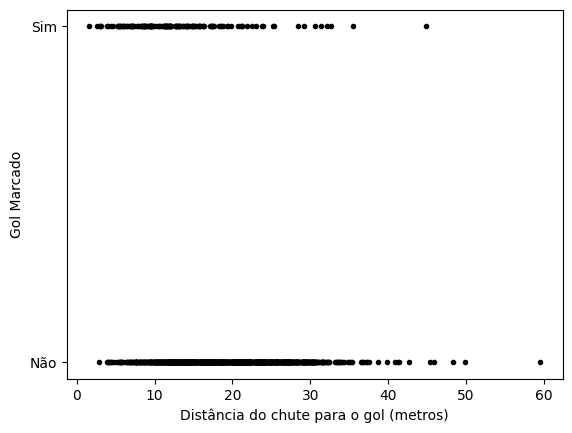

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    shots['dist'],
    shots['gol'],
    linestyle='none',
    marker='.',
    markersize=6,
    color='black',
)
ax.set_ylabel('Gol Marcado')
ax.set_xlabel('Distância do chute para o gol (metros)')
plt.ylim((-0.05, 1.05))
ax.set_yticks([0, 1])
ax.set_yticklabels(['Não', 'Sim'])
plt.show()

## Investigando a relação entre a probabilidade de marcar gols e a distância
Queremos descobrir se a distância influencia a probabilidade de marcar um gol. Primeiro, vamos plotar a probablidade de termos um gol dado o ângulo usando a mesma estratégia de antes: agrupando os dados fazendo a divisão.

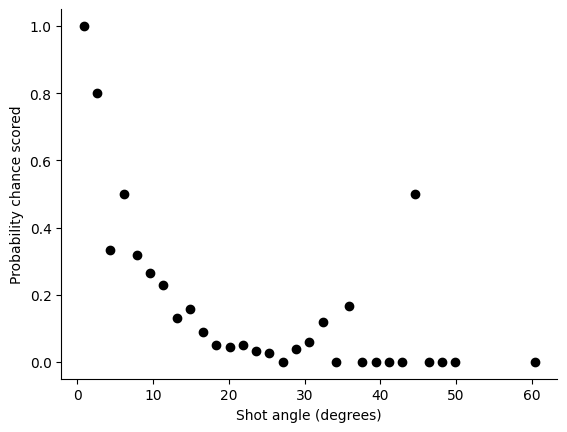

In [ ]:
# number of shots from dist
shotcount_dist = np.histogram(shots['dist'], bins=40, range=[0, 70])

# number of goals from dist
goalcount_dist = np.histogram(
    shots[shots['gol']]['dist'], bins=40, range=[0, 70]
)
np.seterr(divide='ignore', invalid='ignore')

# probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
dist = shotcount_dist[1]
middist = (dist[:-1] + dist[1:]) / 2

# make plot
fig, ax = plt.subplots()
ax.plot(middist, prob_goal, linestyle='none', marker='.', markersize=12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel('Shot angle (degrees)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Ajuste de regressão logística com coeficientes aleatórios
Nosso conjunto de dados foi ajustado a uma curva de regressão logística com parâmetros definidos - 10 para o intercepto e -0.25 para a distância. No entanto, é muito provável que esses não sejam os melhores estimadores dos parâmetros verdadeiros.

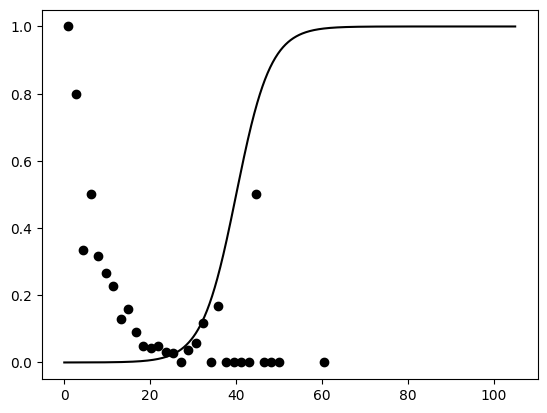

In [ ]:
fig, ax = plt.subplots()
b = [10, -0.25]
x = np.arange(105, step=0.1)
y = 1 / (1 + np.exp(b[0] + b[1] * x ))
# plot line
ax.plot(middist, prob_goal, linestyle='none', marker='.', markersize=12, color='black')
# plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

### Calculando a verossimilhança logarítmica
Os melhores parâmetros são aqueles que maximizam a verossimilhança logarítmica.

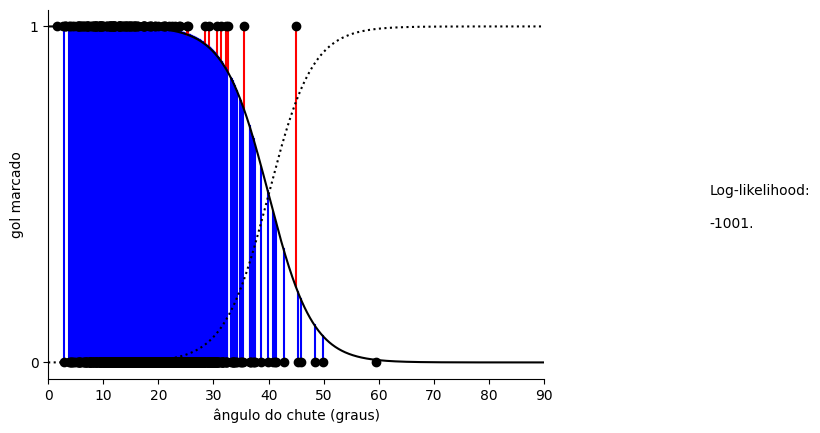

In [ ]:
# calculate xG
xG = 1 / (1 + np.exp(b[0] + b[1] * shots['dist']))
shots = shots.assign(xG_dist=xG)
fig, ax = plt.subplots()

# plot data
ax.plot(
    shots['dist'],
    shots['gol'],
    linestyle='none',
    marker='.',
    markersize=12,
    color='black',
    zorder=3,
)

# plot curves
ax.plot(x, y, linestyle=':', color='black', zorder=2)
ax.plot(x, 1 - y, linestyle='solid', color='black', zorder=2)

# calculate loglikelihood
loglikelihood = 0

for _, shot in shots.iterrows():
    dist = shot['dist']
    if shot['gol'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG_dist'])
        ax.plot([dist, dist], [shot['gol'], 1 - shot['xG_dist']], color='red', zorder=1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG_dist'])
        ax.plot([dist, dist], [shot['gol'], 1 - shot['xG_dist']], color='blue', zorder=1)

ax.set_ylabel('gol marcado')
ax.set_xlabel('ângulo do chute (graus)')
plt.ylim((-0.05, 1.05))
plt.xlim((0, 90))
plt.text(120, 0.5, 'Log-likelihood:')
plt.text(120, 0.4, str(loglikelihood)[:6])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Fitando a regressão logística e encontrando os melhores valores
Os melhores parâmetros são aqueles que maximizam a verossimilhança logarítmica.

Intercept: 0.3831510637527493
Coeficiente angular: -0.14914060765824871


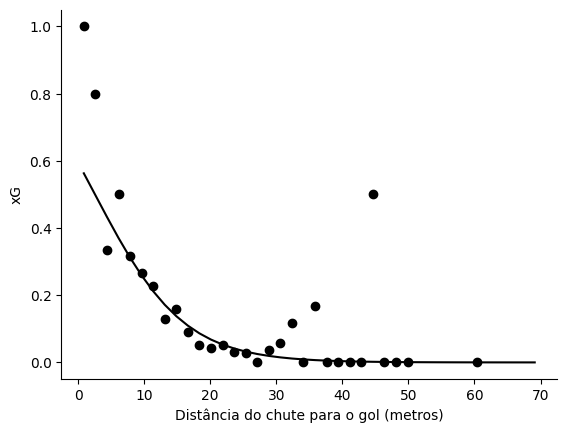

In [ ]:
# Supondo que 'df' seja o dataframe com as colunas 'gol' e 'ang'
X = shots[['dist']].values  # A variável independente
y = shots['gol'].values  # A variável dependente (binária)

# Criando o modelo de regressão logística
model = LogisticRegression()
model.fit(X, y)

# Pegando os parâmetros
b0 = model.intercept_[0]
b1 = model.coef_[0][0]

print(f'Intercept: {b0}')
print(f'Coeficiente angular: {b1}')

# Calculando a probabilidade xG
xGprob = 1 / (1 + np.exp(-1 * (b0 + b1 * middist)))

# Plotando os resultados
fig, ax = plt.subplots()

# Plotando os dados
ax.plot(middist, prob_goal, linestyle='none', marker='.', markersize=12, color='black')

# Plotando a linha de regressão
ax.plot(middist, xGprob, linestyle='solid', color='black')

# Configurando as legendas e eixos
ax.set_ylabel('xG')
ax.set_xlabel('Distância do chute para o gol (metros)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
# setar o xG no dataframe
shots = shots.assign(xG_dist=model.predict_proba(X)[:, 1])
# shots = shots.assign(xG_angle=1 / (1 + np.exp(-1*(b0 + b1 * X))))

## Avaliação do modelo: ROC AUC

Toda vez que criamos modelos, devemos avaliá-los para testar usa eficácia.

A Área Sob A Curva Característica de Operação do Receptor (ROC AUC) é um gráfico que relaciona taxa de verdadeiros positivos (TPR) vs. taxa de falsos positivos (FPR) em diferentes thresholds. Especificamente, sobre a AUC (Área Sob a Curva):
- AUC = 0.5: Desempenho aleatório.
- AUC = 1.0: Modelo perfeito.
Ou seja, quanto maior a AUC, melhor a discriminação do modelo. A vantagem do ROC AUC é que ele independente do threshold e vira uma comparação eficaz entre modelos.

Vamos obter o valor de auc para xG dist

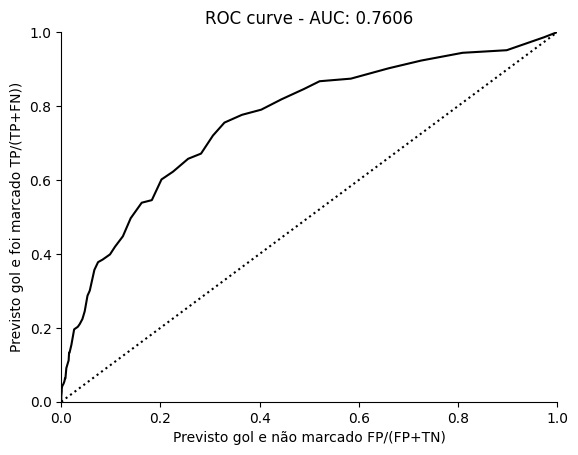

In [ ]:
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for _, shot in shots.iterrows():
        if shot['gol'] == 1:
            if shot['xG_dist'] > threshold:
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if shot['gol'] == 0:
            if shot['xG_dist'] > threshold:
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

auc = roc_auc_score(shots['gol'], shots['xG_dist'])

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel('Previsto gol e foi marcado TP/(TP+FN))')
ax.set_xlabel("Previsto gol e não marcado FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
plt.title(f'ROC curve - AUC: {auc:.4f}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)